## Setup

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans


In [2]:
df_raw = pd.read_csv('./KaDo.csv')

In [3]:
df = df_raw.copy().filter(["PRIX_NET", "NB_T", "MAILLE", "CLI_ID"])

In [4]:
df_raw.columns

Index(['TICKET_ID', 'MOIS_VENTE', 'PRIX_NET', 'FAMILLE', 'UNIVERS', 'MAILLE',
       'LIBELLE', 'CLI_ID'],
      dtype='object')

## Recommandation par profile d'acheteur (Gros acheteur ponctuel VS petit acheteur de tous les jours) 

### 1ere Etape: calculer nbr item par panier et total panier pour chaque client


In [5]:
df["NB_T"] = 1

In [6]:
cart_df = df.groupby(["CLI_ID"], as_index=True).sum()

In [7]:
cart_df.head()

,PRIX_NET,NB_T
CLI_ID,,
1490281,18.40,5
13290776,55.50,9
20163348,7.45,1
20200041,6.70,2
20561854,7.05,3


### 2me Etape: calculer nbr item par panier  par client et total panier par client - pour chaque mail


In [8]:
df_maille = df.copy().filter(["PRIX_NET", "NB_T", "MAILLE", "CLI_ID"])
df_maille.head()

,PRIX_NET,NB_T,MAILLE,CLI_ID
0,1.67,1,HYG_JDM,1490281
1,1.66,1,HYG_JDM,1490281
2,7.45,1,VIS_JEUNE_ET_LEVRE,1490281
3,5.95,1,VIS_AAAR_DEMAQLOTION,1490281
4,1.67,1,HYG_JDM,1490281


In [9]:
nb_client_maille = df_maille.groupby(["MAILLE"], as_index=True).sum().filter(["PRIX_NET", "NB_T"])

mail_df = df.groupby(["MAILLE"], as_index=True).sum()
mail_df.head()

,PRIX_NET,CLI_ID,NB_T
MAILLE,,,
CAPILLAIRE_AUTRE,528209.50,102234425421230,104129
CAPILLAIRE_SHAMPOING,728789.98,193161999044150,197236
CORPS_HYDRA_NOURRI_ET_SOINS,2425255.83,502009961459841,513178
CORPS_HYDR_LAIT_HUILE,895789.28,189829965663141,193406
CORPS_MONOI,484101.73,72170784273078,73579


In [10]:
rmder =  df_maille.groupby(["MAILLE", "CLI_ID"], as_index=True).sum().reset_index()["MAILLE"].value_counts()
rmder.head()

VIS_JEUNE_ET_LEVRE             291937
CORPS_HYDRA_NOURRI_ET_SOINS    241988
HYG_JDM                        236116
HYG_PLAISIRNAT_BAIN_SAVON      207534
PARF_PARFUM                    198095
Name: MAILLE, dtype: int64

In [11]:
final_df = mail_df.join(rmder).rename(columns={"MAILLE": "NB_CLI"}).drop(["CLI_ID"], axis=1).reset_index()

final_df["PRIX_NET"] = final_df["PRIX_NET"] / final_df["NB_CLI"]
final_df["NB_T"] = final_df["NB_T"] / final_df["NB_CLI"]

final_df = final_df.drop(["NB_CLI"], axis=1)
final_df.head()

,MAILLE,PRIX_NET,NB_T
0,CAPILLAIRE_AUTRE,8.990188,1.772288
1,CAPILLAIRE_SHAMPOING,7.418842,2.007798
2,CORPS_HYDRA_NOURRI_ET_SOINS,10.022215,2.120675
3,CORPS_HYDR_LAIT_HUILE,6.983514,1.507780
4,CORPS_MONOI,8.817882,1.340237


### 3eme Etape: calcul cluster client


In [37]:
cart_cluster = cart_df.reset_index()
df_cluster = cart_cluster.filter(['PRIX_NET', 'NB_T'])
X = df_cluster
nb_cluster = 99
kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(X.values)
df_cluster["label"] = kmeans.labels_


In [38]:
df_cluster.head()

,PRIX_NET,NB_T,label
0,18.40,5,79
1,55.50,9,32
2,7.45,1,11
3,6.70,2,11
4,7.05,3,11


#### Cluster graph

<AxesSubplot:xlabel='PRIX_NET', ylabel='NB_T'>

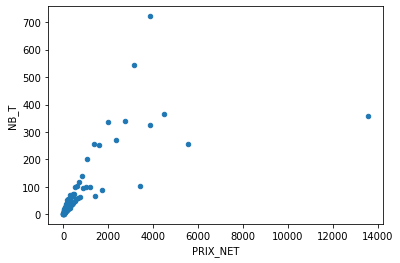

In [39]:
df_cluster_point = pd.DataFrame(kmeans.cluster_centers_, columns=["PRIX_NET", "NB_T"])
df_cluster_point.plot.scatter(x="PRIX_NET", y="NB_T")

In [40]:
df_cluster_point.head()

,PRIX_NET,NB_T
0,18.259294,2.483104
1,153.747281,15.447041
2,414.793836,39.184932
3,62.757657,14.534137
4,3860.350000,325.000000


#### All cient profile clustered graph

(0.0, 150.0)

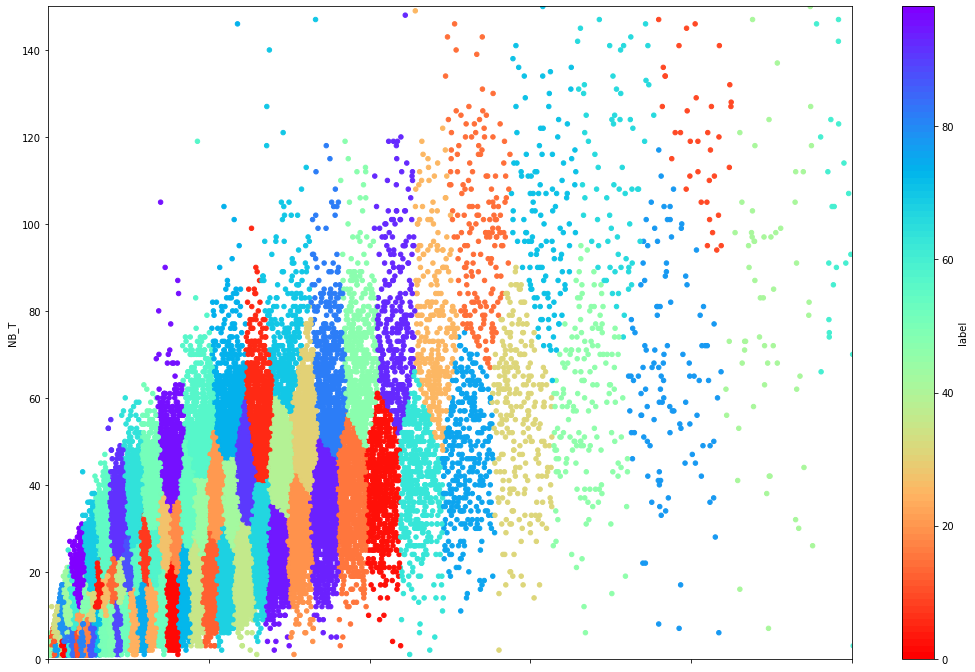

In [61]:
color_map = plt.get_cmap('rainbow', nb_cluster)
reversed_color_map = color_map.reversed()

ax = df_cluster.plot.scatter(x="PRIX_NET", y="NB_T", c="label", colormap=reversed_color_map, figsize=(18,12))

ax.set_xlim([0, 1000])
ax.set_ylim([0, 150])

# for i, txt in enumerate(df_cluster_point.index):
#     ax.annotate(txt, (df_cluster_point["PRIX_NET"].iat[i], df_cluster_point["NB_T"].iat[i]), color='black', fontsize=10)

### 4eme Etape: trouver le cluster depuis un id client


In [46]:
maille_cluster = final_df.filter(['MAILLE', 'PRIX_NET', 'NB_T'])
X = maille_cluster
# kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(X)
# df_cluster["label"] = kmeans.labels_
test = None
for maille in X.values:
    test = kmeans.predict([[maille[1], maille[2]]])
    print(test)

[77]
[11]
[77]
[11]
[77]
[37]
[37]
[11]
[45]
[77]
[11]
[11]
[77]
[77]
[0]
[11]
[77]
[11]
[0]
[77]
[37]
[37]
[45]
[77]
[62]
[84]
[37]
[37]
[81]
[11]
[77]
[37]
[77]
[11]


<AxesSubplot:xlabel='PRIX_NET', ylabel='NB_T'>

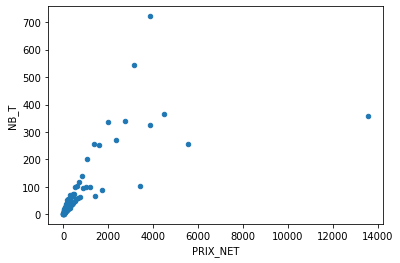

In [45]:
df_cluster_point = pd.DataFrame(kmeans.cluster_centers_, columns=["PRIX_NET", "NB_T"])
df_cluster_point.plot.scatter(x="PRIX_NET", y="NB_T")

### 5eme Etape: trouver quel mail fait parti de se cluster


### 6eme Recommandation dans la mail